#                   Advanced Derivatives 

In [ ]:
from financepy.utils import *
from financepy.products.equity import *
from financepy.products.rates import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings
import seaborn as sns
import datetime 
from dateutil.relativedelta import relativedelta
#To avoid annoying scientific notations
pd.set_option('display.float_format', lambda x: '%.8f' % x)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Various delta hedging analysis

In [18]:
#Creating a function to simulate a stock lognormal process
def stock_simulation(S,u,sigma,T,N):
    dt = T/N
    sqdt = np.sqrt(dt)
    Stock_prices = np.zeros(N)
    Stock_prices[0] = S
    t = np.zeros(N)
    for i in range(1, N):    
        Z = np.random.normal(loc=0.0, scale=1.0, size=1)
        Stock_prices[i] = Stock_prices[i-1] * np.exp((u-sigma*sigma/2)* dt + sigma * Z * sqdt)
        t[i] = i*dt
    #The function returns each stock price at each dt interval
    return Stock_prices

# Function to compute N(d1)
def bs_d_one_simple(S, K, sigma,r, T):
    return (1 / (sigma * T**0.5)) * (np.log(S / K) + (r+sigma**2)/2 * T)

#Returns option price and its delta
def compute_prices_simple(pxs, K, sigma, T,r, call=True):
    # calculate d1 and d2
    d_one = bs_d_one_simple(pxs, K, sigma,r, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K*np.exp(-r*T)
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K*np.exp(-r*T) + deltas * pxs
    
    return prices, deltas

In [8]:
def OptionSim(S,K,r,u,sigma,T,N):
    
    dt=T/N
    
    #Simulate prices from our previously defined stock_simulation function
    prices= stock_simulation(S,u,sigma,T,N)
    
    op_pxs,deltas = [],[]
    
    #Loop over time to consider time decreasing when valuing our option
    for i in range(N):
        op_pxs.append(compute_prices_simple(prices[i], K, sigma, T-i*dt,r, call=True)[0])
        deltas.append(compute_prices_simple(prices[i], K, sigma, T-i*dt,r, call=True)[1])
        
    #Calculating  the amount of shares we will have to buy/sell at each new hedging time
    deltas_spread= np.diff(deltas)
    rehedge = -deltas_spread*prices[1:]
    
    #Initializing our cash_balance
    start_cbs = op_pxs[0] - deltas[0] * prices[0]
    cash_balance = [start_cbs]
    #Initializing our stock_position_value
    stock_position_value = []
    stock_position_value.append(deltas[0] * prices[0])
    #The portfolio is equal to the cash_balance +  the stock_position_value
    portfolio=[]

    for dcf in rehedge:
        # get previous cash balance
        prev_cash = cash_balance[-1]
        # future value it
        new_cash = prev_cash *np.exp(r*dt) #<= we take into account lending/borrowing at each new hedging period (dt)
        # add on new cash flows
        cf = dcf
        cb = new_cash + cf
        cash_balance.append(cb)

    for i in range(1,len(prices)):
        stock_position_value.append(prices[i]*deltas[i])

    for i in range(len(prices)):
        portfolio.append(cash_balance[i]+stock_position_value[i])
    
    final_stock_price = prices[-1]
    call_payoff = max(prices[-1]-K,0)
    #Numbers of shares held at the end
    nb_shares = deltas[-1]
    final_cash_balance = cash_balance[-1]
    final_portfolio = portfolio[-1]
    #Difference between the portfolio value and the option payoff
    final_error = final_portfolio - call_payoff
    return (final_stock_price,call_payoff,nb_shares,final_cash_balance,final_portfolio,final_error)


In [9]:
#Option simulation with S=100,K=100,r=0.05,u=r,sigma=0.2,T=1 year,N=12 (monthly hedging)
OptionSim(100,100,0.05,0.05,0.2,1,12)

(81.77335868091869,
 0,
 0.00031280893101927245,
 1.357534735338092,
 1.3831141722529257,
 1.3831141722529257)

Calculate the hedging error over 1,000 different paths.

In [10]:
#We simulate n instances of our OptionSim function to get n hedging errors and the final stock price
def OptionSim_hedging_errors(S,K,r,u,sigma,T,N,nb_simulations):
    final_stock_prices = []
    hedging_errors = []
    final_portfolios=[]
    call_payoffs=[]
    abs_hedging_errors =[]
    
    for i in range(nb_simulations):
        
        results = OptionSim(S,K,r,u,sigma,T,N)
        final_stock_prices.append(results[0])
        call_payoffs.append(results[1])
        final_portfolios.append(results[4])
        hedging_errors.append(results[5])
        abs_hedging_errors.append(abs(results[5]))
        
    #We included the mean and variance to answer question f 
                                  
    errors_mean=np.average(abs_hedging_errors)
    errors_variance=np.var(hedging_errors)
        
    return (final_stock_prices,call_payoffs,final_portfolios,hedging_errors,errors_mean,errors_variance)
        

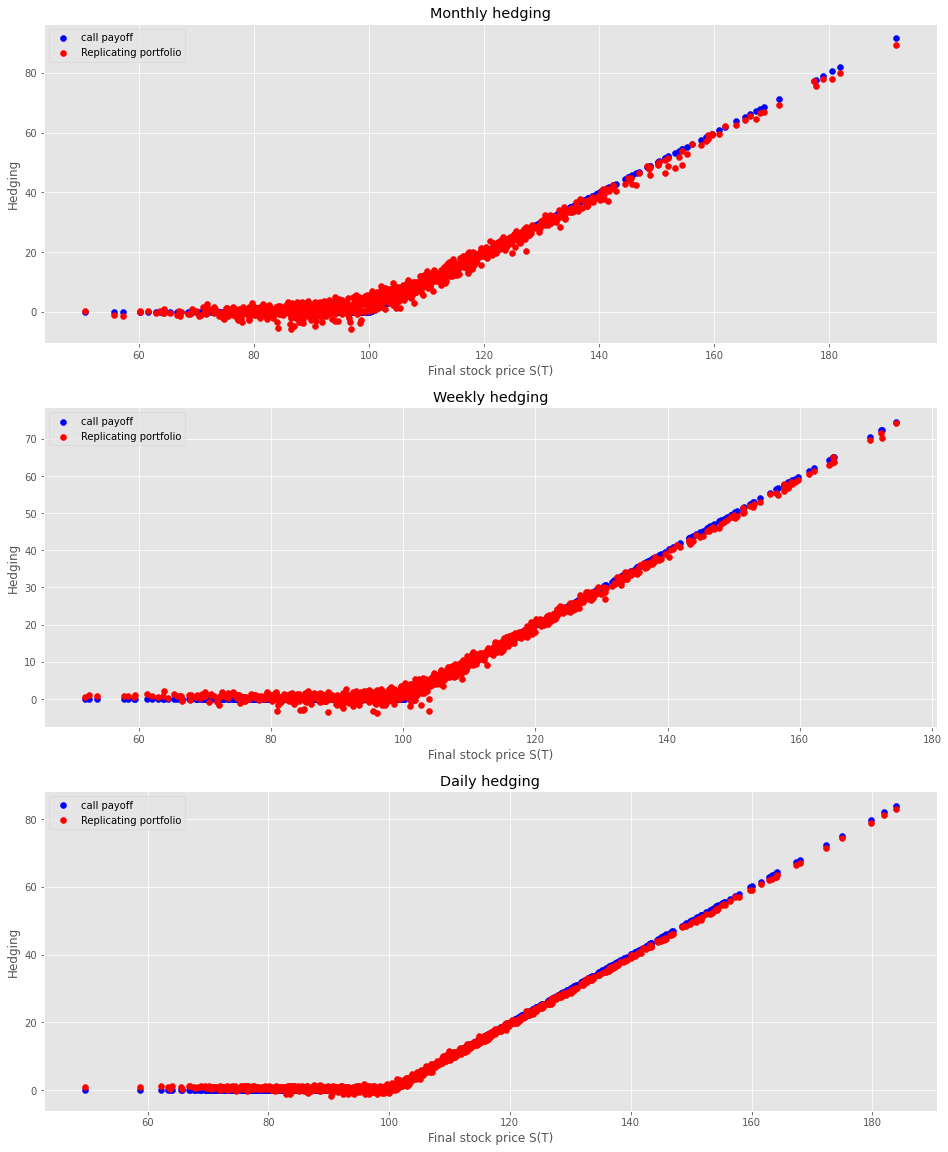

In [36]:
#Create a scatter plot with different hedging frequencies

frequencies=[12,52,252]
Titles = ["Monthly hedging","Weekly hedging","Daily hedging"]
i=1
a=0
plt.figure(figsize=(16,20))
for f in frequencies:

    data = OptionSim_hedging_errors(100,100,0.05,0.05,0.2,1,f,1000)
    plt.subplot(3,1,i)
    plt.scatter(data[0],data[1],label="call payoff",c="blue")
    plt.scatter(data[0],data[2],c='red',label='Replicating portfolio')
    plt.xlabel("Final stock price S(T)")
    plt.ylabel("Hedging")
    plt.title(f"{Titles[a]}")
    i+=1
    a+=1
    plt.legend()

Calculation of the mean and variance of this option hedging error
over 1,000 different paths.


In [43]:
for f in frequencies:
    results = OptionSim_hedging_errors(100,100,0.05,0.05,0.2,1,f,1000)
    print(f"mean error for N = {f} : {results[4]}, variance : {results[5]}")
    

mean error for N = 12 : 1.6674931318690887, variance : 4.364810336910235
mean error for N = 52 : 0.9159881744554841, variance : 1.3122704441324209
mean error for N = 252 : 0.6475092152019359, variance : 0.5577601235378127


Logically, when we increase the hedging frequency, we minimize the error (but we also increase transaction costs !)

Mean absolute error value and the variance
of the hedging error for µ = 2.5%, 5.0%, 7.5%, 10% by sampling P = 10, 000 hedging
paths using N = 52.


In [45]:
#Computing the mean absolute error value and the variance of the hedging error for µ = 2.5%, 5.0%, 7.5%, 10% by sampling P = 10,000 hedging
# paths using N = 52.

expected_returns = [0.025,0.05,0.075,0.1]
i=0

df=pd.DataFrame(columns=["Mean_absolute_error","Variance_error"])
df["expected_returns"] = expected_returns
df=df.set_index("expected_returns")

for µ in expected_returns :
    results = OptionSim_hedging_errors(100,100,0.05,µ,0.2,1,52,10000)
    df.Mean_absolute_error[i] = results[4]
    df.Variance_error = results[5]
    i+=1

df
   

,Mean_absolute_error,Variance_error
expected_returns,,
0.02500000,0.91316010,1.25730223
0.05000000,0.92020625,1.25730223
0.07500000,0.92201537,1.25730223
0.10000000,0.90165656,1.25730223


These results tell us that whatever the drift is it does not change (at least not too much) the mean error when we implement our hedging strategy.
In other words, if the stock grows at a faster rate (µ increasing), it does not change our hedging exposure since the mean error remains pretty much the same.

Option hedging using a dataframe.

In [27]:
def OptionSim(S,K,r,u,sigma,T,N):
    df=pd.DataFrame()
    dt=T/N
    #Get our stock lognormal process 
    df['stock_prices'] = stock_simulation(S,u,sigma,T,N)
    #Initialize our delta series
    df['deltas'] = np.zeros(N)
    #Getting the first call delta with full maturity T
    df['deltas'] = compute_prices_simple(df.stock_prices[0], K, sigma, T,r, call=True)[1]
    #Initialize our call prices series
    df["call_price"]= np.zeros(N)
    #Getting the first call price with full maturity T
    df["call_price"][0]= compute_prices_simple(df.stock_prices[0], K, sigma, T,r, call=True)[0]
    #Initialize our cash balance series
    df['cash_balance']=np.zeros(N)
    #Computing our cash balance at time 0
    df["cash_balance"][0]= df.call_price[0] - df.deltas[0] * df.stock_prices[0]
    #Initialize our portfolio value series
    df["portfolio_value"] = np.zeros(N)
    #Computing our portfolio value at time 0
    df["portfolio_value"][0] = df.deltas[0] * df.stock_prices[0] 
    #Initialize our deltas spread series
    df["deltas_spread"]=np.zeros(N)
    df["Value_of_the_position"] =np.zeros(N)
    df["Value_of_the_position"][0] =  df['cash_balance'][0] +  df["portfolio_value"][0] - df["call_price"][0]
    df["intrinsic_call_payoff"]= [max(final_price-K,0) for final_price in df.stock_prices]
    
    for i in range(1,N):
        
        df["call_price"][i]= compute_prices_simple(df.stock_prices[i], K, sigma, T-(i*dt),r, call=True)[0]
        df['deltas'][i] = compute_prices_simple(df.stock_prices[i], K, sigma, T-(i*dt),r, call=True)[1]
        df["deltas_spread"][i] =df.deltas[i]-df.deltas[i-1]
        df["portfolio_value"][i] = df.stock_prices[i]*df.deltas[i]
        df["cash_balance"][i] = df.cash_balance[i-1]*np.exp(r*dt) - df.deltas_spread[i]*df.stock_prices[i]
        df["Value_of_the_position"][i] = df["portfolio_value"][i] + df["cash_balance"][i] -df.call_price[i]
        
    return df
    


In [28]:
OptionSim(100,100,0.01,0.1,0.3,1,200)

,stock_prices,deltas,call_price,cash_balance,portfolio_value,deltas_spread,Value_of_the_position,intrinsic_call_payoff
0,100.00000000,0.56618383,12.36663241,-44.25175085,56.61838326,0.00000000,0.00000000,0.00000000
1,104.26103849,0.62007979,14.89077156,-49.87321243,64.65016331,0.05389596,-0.11382068,4.26103849
2,106.61344891,0.64816519,16.36511814,-52.86998731,69.10312663,0.02808540,-0.13197882,6.61344891
3,109.98712903,0.68620773,18.60477247,-57.05682061,75.47401839,0.03804254,-0.18757470,9.98712903
4,111.57658124,0.70327226,19.68625455,-58.96367483,78.46871410,0.01706452,-0.18121528,11.57658124
...,...,...,...,...,...,...,...,...
195,95.44205224,0.16924953,0.40224609,-15.92739859,16.15352223,0.10064623,-0.17612245,0.00000000
196,94.12569413,0.08025615,0.14366098,-7.55163172,7.55416598,-0.08899338,-0.14112672,0.00000000
197,92.29386167,0.01530322,0.01833162,-1.55725212,1.41239297,-0.06495293,-0.16319078,0.00000000
198,89.79718867,0.00017812,0.00011869,-0.19913845,0.01599430,-0.01512510,-0.18326283,0.00000000


# Delta hedging when bid/ask spread is taking into account

In [29]:
# We amended our code to have a round trip bid/ask transaction cost of µ%, lets say that µ = 0.00005%
# We just deduct the bid/ ask cost from the cash balance at each trade so we add one more argument t our function µ.

def OptionSim_with_bid_ask_costs(S,K,r,u,sigma,T,N,µ):
    
    dt=T/N
    
    #Simulate prices from our previously defined stock_simulation function
    prices= stock_simulation(S,u,sigma,T,N)
    
    op_pxs,deltas = [],[]
    
    #Loop over time to consider time decreasing when valuing our option
    for i in range(N):
        op_pxs.append(compute_prices_simple(prices[i], K, sigma, T-i*dt,r, call=True)[0])
        deltas.append(compute_prices_simple(prices[i], K, sigma, T-i*dt,r, call=True)[1])
        
    #Calculating  the amount of shares we will have to buy/sell at each new hedging time
    deltas_spread= np.diff(deltas)
    rehedge = -deltas_spread*prices[1:]
    
    #Initializing our cash_balance
    start_cbs = op_pxs[0] - deltas[0] * prices[0]
    cash_balance = [start_cbs]
    #Initializing our stock_position_value
    stock_position_value = []
    stock_position_value.append(deltas[0] * prices[0])
    #The portfolio is equal to the cash_balance +  the stock_position_value
    portfolio=[]
    i=1

    for dcf in rehedge:
        # get previous cash balance
        prev_cash = cash_balance[-1]
        # future value it
        new_cash = prev_cash*np.exp(r*dt) - µ*prices[i] # <== We take into account the bid/ask cost here
        # add on new cash flows
        cf = dcf
        cb = new_cash + cf
        cash_balance.append(cb)
        i+=1

    for i in range(1,len(prices)):
        stock_position_value.append(prices[i]*deltas[i])

    for i in range(len(prices)):
        portfolio.append(cash_balance[i]+stock_position_value[i])
    
    final_stock_price = prices[-1]
    call_payoff = max(prices[-1]-K,0)
    #Numbers of shares held at the end
    nb_shares = deltas[-1]
    final_cash_balance = cash_balance[-1]
    final_portfolio = portfolio[-1]
    #Difference between the portfolio value and the option payoff
    final_error = final_portfolio - call_payoff
    
    return (final_stock_price,call_payoff,nb_shares,final_cash_balance,final_portfolio,final_error)

In [30]:
#Option simulation with S=100,K=100,r=0.05,u=r,sigma=0.2,T=1 year,N=12 (monthly hedging), bid/ask cost = 0.00005
OptionSim_with_bid_ask_costs(100,100,0.05,0.05,0.2,1,12,0.00005)

(122.61310677949477,
 22.61310677949477,
 0.9998384108522671,
 -100.27945721748738,
 22.313836614582016,
 -0.2992701649127554)

In [33]:
def OptionSim_hedging_errors_with_bid_ask_costs(S,K,r,u,sigma,T,N,nb_simulations,µ):
    final_stock_prices = []
    hedging_errors = []
    final_portfolios=[]
    call_payoffs=[]
    
    for i in range(nb_simulations):
        
        results = OptionSim_with_bid_ask_costs(S,K,r,u,sigma,T,N,µ) # <= return a tuple of 6 elements
        final_stock_prices.append(results[0])
        call_payoffs.append(results[1])
        final_portfolios.append(results[4])
        hedging_errors.append(results[5])
        
    #We included the mean and variance to answer question f 
                                  
    errors_mean=np.average(hedging_errors)
    errors_variance=np.var(hedging_errors)
        
    return (final_stock_prices,call_payoffs,final_portfolios,hedging_errors,errors_mean,errors_variance)

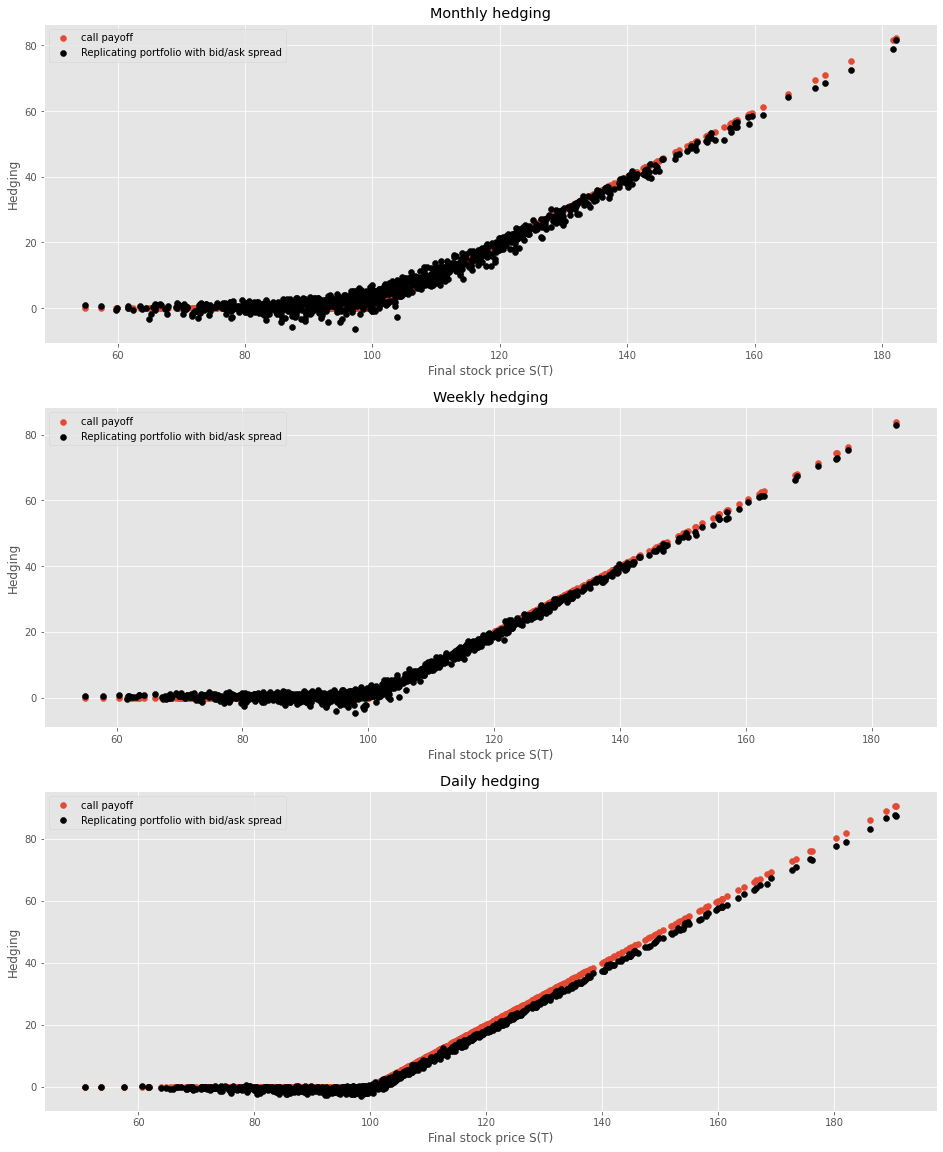

In [34]:
#Create a scatter plot with different hedging frequencies taking into account transaction costs

frequencies=[12,52,252]
Titles = ["Monthly hedging","Weekly hedging","Daily hedging"]
i=1
a=0
plt.figure(figsize=(16,20))
for f in frequencies:

    data = OptionSim_hedging_errors_with_bid_ask_costs(100,100,0.05,0.05,0.2,1,f,1000,0.00005)
    plt.subplot(3,1,i)
    plt.scatter(data[0],data[1],label="call payoff")
    plt.scatter(data[0],data[2],c='black',label='Replicating portfolio with bid/ask spread')
    plt.xlabel("Final stock price S(T)")
    plt.ylabel("Hedging")
    plt.title(f"{Titles[a]}")
    i+=1
    a+=1
    plt.legend()

We can observe that the bid/ask cost increases hedging errors !

Mean hedging error value for an annual heding frequency of N =
12, 52, 250 with ϕ = 0.5%, 1.0%, 2.0% by sampling across P = 1, 000 hedging paths.


In [35]:
#Computing the mean absolute error for µ(transaction costs) = 0.5%, 1.0%, 2%  by sampling P = 1000 hedging
# paths using N = 12,52,252

periods=[12,52,252]
bid_ask_costs = [0.005,0.01,0.02]
i=0

df_transaction_costs=pd.DataFrame(columns=['Mean_error_periods=12','Mean_error_periods=52','Mean_error_periods=252'])
df_transaction_costs["bid_ask_costs"] = bid_ask_costs
df_transaction_costs=df_transaction_costs.set_index("bid_ask_costs")

for N in periods:
    i=0
    for µ in bid_ask_costs :
        results = OptionSim_hedging_errors_with_bid_ask_costs(100,100,0.05,0.05,0.2,1,N,1000,µ) 
        df_transaction_costs[f"Mean_error_periods={N}"][i] = abs(results[4])
        i+=1

df_transaction_costs

,Mean_error_periods=12,Mean_error_periods=52,Mean_error_periods=252
bid_ask_costs,,,
0.00500000,5.35679736,26.72314475,131.69301819
0.01000000,11.01002084,53.55889646,263.28289636
0.02000000,22.47799670,106.69885008,528.48692635


We can observe that the more often we hedge, the more transaction costs we pay.

Leland (Journal of Finance, 1985) showed that the cost of hedging taking into account
hedging costs is equivalent to adjusting the volatility as follows
σ
Adjusted = σ

1 + r
2
π
ϕ
σ
√
N
!1/2
(1)
where ϕ is the round-trip transaction cost as a percentage of the stock price, σ is the
stock volatility and N is the annual hedging frequency.


In [95]:
# Implementing the Leland adjusted volatility to take into account bid/ask cost with Financepy.
bid_ask_costs = [0.005,0.01,0.02]
sigma=0.2

valuation_date = Date(1, 1, 2022)
expiry_date = valuation_date.add_years(0.5)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate, FrequencyTypes.CONTINUOUS)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
model = BlackScholes(0.2)

def leland(valuation_date, stock_price, sigma, discount_curve, dividend_curve, N):
    
    leland_df = pd.DataFrame(index=['Call Price'])
    
    leland_df["BS non-adjusted"] = 0  
    leland_df["BS adjusted 0.5%"] = 0 
    leland_df["BS adjusted 1.0%"] = 0 
    leland_df["BS adjusted 2.0%"] = 0 
        
    sigma_a05 = sigma * (1 + np.sqrt(2/np.pi)*(0.005/sigma)*np.sqrt(N))**0.5
    sigma_a10 = sigma * (1 + np.sqrt(2/np.pi)*(0.01/sigma)*np.sqrt(N))**0.5
    sigma_a20 = sigma * (1 + np.sqrt(2/np.pi)*(0.02/sigma)*np.sqrt(N))**0.5
    
    model = BlackScholes(sigma)
    model05 = BlackScholes(sigma_a05)
    model10 = BlackScholes(sigma_a10)
    model20 = BlackScholes(sigma_a20)
    
    leland_df.loc["Call Price","BS non-adjusted"] = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
    leland_df.loc["Call Price","BS adjusted 0.5%"] = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model05)
    leland_df.loc["Call Price","BS adjusted 1.0%"] = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model10)
    leland_df.loc["Call Price","BS adjusted 2.0%"] = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model20)
    
        
    return leland_df

valuation_date = Date(1, 1, 2022)
expiry_date = valuation_date.add_years(0.5)
stock_price = 100
strike_price = 100
sigma = 0.2
call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate, FrequencyTypes.CONTINUOUS)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
N = 52

leland(valuation_date, stock_price, sigma, discount_curve, dividend_curve, N)

,BS non-adjusted,BS adjusted 0.5%,BS adjusted 1.0%,BS adjusted 2.0%
Call Price,6.85531629,7.23447184,7.59093337,8.24937602


Logically, when the bid/ask cost increases, so does the option price.

# Volatility smile analysis

We suppose that we have managed to fit the 1-year volatility smile of the equity option
market using a function
σ(x) = ax2 + bx + c
where x is the ”moneyness” (x = K/S(0)) and the initial stock price S(0) = 100
and a = 0.025, b = −0.225 and c = 0.50. We built a Python function that extracts the
market-implied distribution of S(T) at a 1-year horizon from σ(x) using the BreedonLitzenberger formula.

In [57]:
S=100
r=0.05
T=1

#To draw a fitting curve from some implied volatility data points
def volatility_interpolated(x):
    return 0.025*x**2 -0.225*x +0.5

def implied_distribution(S,T,r,df=False,plot=False):
    global options_volatility
    discount_factor = 1/np.exp(-r*T)
    option_strikes=[]
    Moneyness=[]
    options_volatility = []
    bs_option_prices =[]
    D2V_D2K =[]
    density = []

    for k in range(1,201):
        #We set up the strikes with a increment equal to one
        option_strike=k
        moneyness = k/S
        #Compute the corresponding implied volatility
        option_volatility = volatility_interpolated(moneyness)
        bs_option_price = compute_prices_simple(S, k, option_volatility, T, r, call=True)[0] #<= indice 0 to get option price

        option_strikes.append(option_strike)
        Moneyness.append(moneyness)
        options_volatility.append(option_volatility)
        bs_option_prices.append(bs_option_price)

    for i in range(1,201):
        if i<199:
            d2v_d2k = bs_option_prices[i+1]-2*bs_option_prices[i]+bs_option_prices[i-1] # here we don not need to divide since dk =1
            D2V_D2K.append(d2v_d2k)
            discounted_d2v_d2k=d2v_d2k*discount_factor
            density.append(discounted_d2v_d2k)
    
    #Plotting the implied distribution
    if plot == True:
        plt.figure(figsize=(16,8))
        plt.plot(np.linspace(0.5,1.3,len(density)),density)
        plt.title("Density implied by the market")
        plt.xlabel("Moneyness")
        plt.ylabel("Distribution")
        plt.legend()
    
    #Creating a dataframe
    if df==True:
        df = pd.DataFrame(list(zip(option_strikes,Moneyness,options_volatility,bs_option_prices,D2V_D2K,density)),columns =["option_strikes","Moneyness","options_volatility","bs_option_prices","d2v_d2k","Density"])
        df.set_index("option_strikes",inplace=True)
        print(f"Sum density: {sum(density)}")
        return df
    
    else :
        return density        

No handles with labels found to put in legend.


[2.9878921633781606e-13,
 1.7613624303114257e-11,
 3.245747257077696e-10,
 2.887782836444175e-09,
 1.5886503116995144e-08,
 6.256988303766575e-08,
 1.9346174489294225e-07,
 4.990335959573133e-07,
 1.1197049093431057e-06,
 2.2510688726969295e-06,
 4.143684087297507e-06,
 7.0979520062150915e-06,
 1.1455289117278e-05,
 1.758703478184206e-05,
 2.5882447273447995e-05,
 3.6736890473877797e-05,
 5.0541001912513194e-05,
 6.767133724272776e-05,
 8.848273638656191e-05,
 0.00011330246747523519,
 0.00014242607022802367,
 0.0001761147387230589,
 0.0002145940381723411,
 0.0002580537305782314,
 0.0003066484921114207,
 0.0003604993136256236,
 0.00041969540322779223,
 0.00048429643073789105,
 0.0005543349810322126,
 0.0006298191085268434,
 0.0007107349048377337,
 0.0007970490134206214,
 0.0008887110413975859,
 0.0009856558319685546,
 0.001087805574610143,
 0.0011950717362250566,
 0.0013073568090141898,
 0.001424555870821139,
 0.0015465579630584332,
 0.0016732472914069384,
 0.0018045042586554822,
 0.001

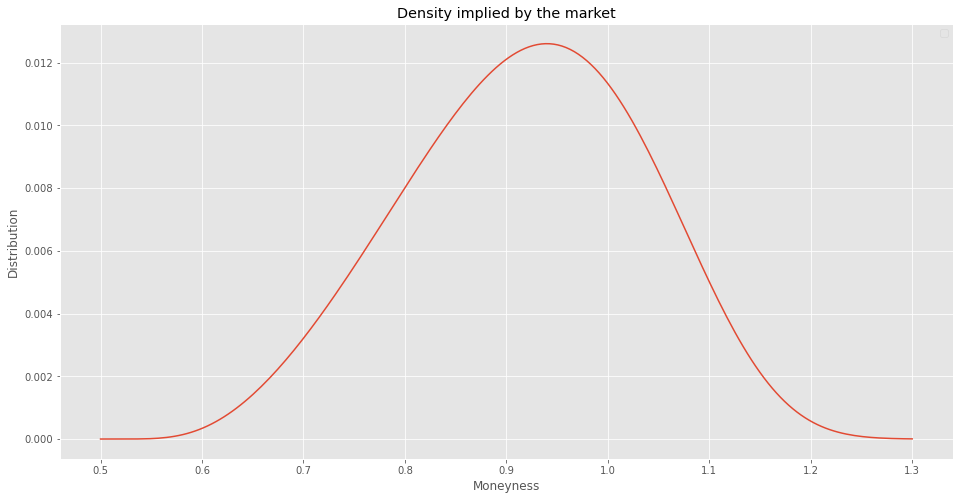

In [58]:
implied_distribution(S,T,r,plot=True)

Using our new distribution to price a digital call option that pays $1 if S(T) > K and zero otherwise with strikes at K = 60, 80, 100, 120, 140. 

In [59]:
r=0.05
T=1
strikes=[60, 80, 100, 120, 140]

df_digital_call_prices=pd.DataFrame(columns=["Digital_option_price"])
df_digital_call_prices["Strikes"] = strikes
df_digital_call_prices.set_index("Strikes",inplace=True)
payoffs=[]

for strike in strikes: # <= ranging from 1 to 200
    probability =  1 - sum(implied_distribution(S,T,r)[0:strike]) # P(ST>K)
    discounted_probability = np.exp(-r*T)*probability
    payoff = discounted_probability # Since the payoff is equal to 1
    payoffs.append(payoff)
    
df_digital_call_prices["Digital_option_price"] = payoffs
df_digital_call_prices   


,Digital_option_price
Strikes,
60,0.87345107
80,0.73805681
100,0.53160466
120,0.29544232
140,0.10715427


Comparing it to BS formula


In [83]:
# Pricing of a binary call option with BS

def digital_option_price(S,K,r,T,sigma,call=True):
    d_one = bs_d_one_simple(S, K, sigma,r, T)
    d_two = d_one - sigma * T**0.5
    Nd1 = stats.norm.cdf(d_one)
    Nd2 = stats.norm.cdf(d_two)
    if call :
        return Nd2 *np.exp(-r*T)
    if not call :
        return (1-Nd2) *np.exp(-r*T)  
        

df_digital_call_prices_BS=pd.DataFrame(columns=["Digital_option_price"])
df_digital_call_prices_BS["Strikes"]= strikes
df_digital_call_prices_BS.set_index("Strikes",inplace=True)
    
df_digital_call_prices_BS["Digital_option_price"] =[digital_option_price(100, strike, r, 1, 0.3) for strike in strikes]
    
df_digital_call_prices_BS


,Digital_option_price
Strikes,
60,0.90280152
80,0.71422403
100,0.45033440
120,0.23783292
140,0.11164511


Our results are consistent with two different stock distributions.
On the one hand the market implied distribution thinks (compared with the lognormal distribution) that there are greater probabilities to see the final stock price to go at extremes low (below 60 in our case). On the other hand it thinks that high final stock prices are less likely to occur (above 140).

Hence, if the strike is 60 for instance, the market thinks that the probability to see the final stock price below 60 is higher than the probability implied by Black and Scholes formula so the price is cheaper (since payoff = 0 for a call option). Similarly, the market thinks that the probability to see the final stock price above 140 is lower than the probability implied by Black and Scholes formula so the price is also cheaper (since it is a call option).

(e) Calculate the value of a put option with strike 100 which only pays out if the stock
falls below $60 at expiry (this is a European and not a path dependent option). Explain
carefully and clearly how this was done.


To find the pricing formula for a digital put option we have two possibilities:

The first one is to solve S(T) < K with S(T) = S(0)*exp((µ-sigma^2)T) + sigma *x*sqrt(T)) where x follows N(0,1).
When we resolve this we find that S(T) < K <=> x < N(-d2). So the price would be exp(-r*T) N(-d2).

The second approach is to go through put call parity. 
For digital put and call with a payoff equal to 1 the put call parity is p + c = exp(-r*T) and as c = N(d2)*exp(-r*T) <=> p =  N(-d2)*exp(-r*T).
We find the same result.

In [86]:
digital_option_price(100,60,0.05,1,0.3,call=False)

0.04842790460554934

We can check if our prices are correct. To do so, we just have to compute call + put and from the put call parity, we should find that call + put = payoff * exp(-rT).
So, in our case (since payoff = 1) call + put = exp(-rT).

In [89]:
call = digital_option_price(100,60,0.05,1,0.3,call=True)
put = digital_option_price(100,60,0.05,1,0.3,call=False)
discounted_payoff = np.exp(-0.05*1)
print(f"Value of call + put: {call + put}, value implied by the put-call parity: {discounted_payoff}")

Value of call + put: 0.951229424500714, value implied by the put-call parity: 0.951229424500714


# Capture the volatility skew to price equity options using the CEV model and Monte Carlo simulation

In [337]:
stock_price = 100
volatility = 0.2 
risk_free_rate = 0.05
dividend_rate = 0 
steps_number = 25
maturity_in_years = 0.5
simulations_number = 10000
strikes = np.linspace(80,120,9)
discount_factor = exp(-risk_free_rate*maturity_in_years)

In [340]:
# Function that generates a stock price process using Monte Carlo with antithetics under the CEV model.

beta = 0

def Monte_Carlo_CEV(stock_price, volatility, risk_free_rate, dividend_rate, steps_number, maturity_in_years , beta, simulations_number, option_type, strike): 
    
    if simulations_number % 2 != 0 : 
        raise TypeError("The number of simulations has to be even")
        
    if option_type.upper() != 'CALL' and option_type.upper() != 'PUT':
        raise TypeError("The option type has to be either 'call' or 'put'")
    
    dt = maturity_in_years / steps_number
    discount_factor = exp(-risk_free_rate*maturity_in_years)
    
    MC_Sims = np.zeros((simulations_number,steps_number))
    MC_Step = stock_price
    
    for i in range(simulations_number):
        MC_Sims[i][0]= MC_Step 
        next
    
    np.random.seed(333)
    g = np.random.normal(0,1, (simulations_number, steps_number))
    
    for j in range(0,simulations_number,2):
        MC_Step = stock_price 
        ant_MC_Step = stock_price
        k=int(j/2)
        for i in range(1, steps_number) : 
            MC_Step = MC_Step*(1 + (risk_free_rate - dividend_rate)*dt + volatility * (MC_Step/stock_price)**(beta) * g[k][i]*sqrt(dt))
            ant_MC_Step = ant_MC_Step*(1 + (risk_free_rate - dividend_rate)*dt + volatility * (ant_MC_Step/stock_price)**(beta) * (-g[k][i])*sqrt(dt))
            MC_Sims[j][i]= MC_Step 
            MC_Sims[j+1][i]= ant_MC_Step 
            next
    simulations = np.array(MC_Sims)
    
    final_prices =[]
    for i in range(simulations.shape[0]):
        final_prices.append(simulations[i][steps_number-1])
        next
    
    if isinstance(strike, np.ndarray): 
        strike = strike
    else : 
        strike = np.array([strike])
        
    option_payoff=np.zeros((strike.shape[0],simulations.shape[0]))
    
    if option_type.upper() == "CALL" :
        for j in range(strike.shape[0]):
            for i in range(len(final_prices)):
                if final_prices[i] - strike[j] > 0 : 
                    option_payoff[j][i]=(final_prices[i]-strike[j])
                else : 
                    option_payoff[j][i]=0
                next
        next
    else : 
        for j in range(strike.shape[0]):
            for i in range(len(final_prices)):
                if strike[j] - final_prices[i] > 0 : 
                    option_payoff[j][i]=(strike[j]-final_prices[i])
                else : 
                    option_payoff[j][i]=0
                next
        next
    
    option_payoff = np.array(option_payoff)
    option_price = np.zeros(strike.shape[0])
    
    for i in range(option_payoff.shape[0]):
        option_price[i] = discount_factor * np.mean(option_payoff[i])
        next 
        
    return option_price

Using the CEV model we price a 6-month call option where S(0) = 100, r = 5%
and σ = 20% for K = 80 to K = 120 in steps of 5 dollars. We do this for
β = −0.5, −0.25, 0.0, 0.25, 0.5. Use P = 10, 000 paths to ensure reasonable accuracy.


In [344]:
#Capture option prices for different betas
betas = np.linspace(-0.5,0.5,5)
option_prices = []
for i in range(betas.shape[0]): 
    option_prices.append(Monte_Carlo_CEV(stock_price, volatility, risk_free_rate, dividend_rate, steps_number, maturity_in_years , betas[i], simulations_number, "call", strikes))
    next 
option_prices

[array([22.14685891, 17.62860639, 13.45686872,  9.78769331,  6.74604224,
         4.37925721,  2.66805327,  1.52464937,  0.82351379]),
 array([22.1169039 , 17.58769344, 13.41541154,  9.76080867,  6.7476739 ,
         4.4121192 ,  2.72513031,  1.59202258,  0.88743586]),
 array([22.08989064, 17.549174  , 13.3754217 ,  9.73515793,  6.75030786,
         4.44622163,  2.78384232,  1.66198121,  0.95520373]),
 array([22.06595137, 17.51306608, 13.33695901,  9.71069912,  6.7538775 ,
         4.48160829,  2.84430124,  1.7347287 ,  1.02694469]),
 array([22.04486481, 17.47936699, 13.29996386,  9.68748771,  6.75839083,
         4.51845151,  2.90675192,  1.81049269,  1.10300514])]

Using the FinancePy implied volatility function (you need to create an EquityVanillaOption object which has an implied volatility function), we convert the prices calculated previously to implied volatilities to show the model-implied skew. 

In [354]:
valuation_date = Date(1, 1, 2022)
expiry_date = valuation_date.add_years(0.5)
stock_price = 100
interest_rate = 0.05
dividend_yield = 0.0
discount_curve = DiscountCurveFlat(valuation_date, interest_rate, FrequencyTypes.CONTINUOUS)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

In [357]:
strikes = np.linspace(80,120,9)
implied_vol = np.zeros((betas.shape[0],strikes.shape[0]))

for i in range(betas.shape[0]):
    for j in range(strikes.shape[0]):
        call_option = EquityVanillaOption(expiry_date, strikes[j], OptionTypes.EUROPEAN_CALL)
        implied_vol[i][j] = call_option.implied_volatility(valuation_date, stock_price, discount_curve, dividend_curve, option_prices[i][j])    
        next
    next  
implied_vol

array([[0.19845261, 0.20002779, 0.19924137, 0.19773104, 0.19598928,
        0.19388876, 0.19171881, 0.18971069, 0.18828797],
       [0.19231712, 0.19607682, 0.19680077, 0.19657308, 0.19604918,
        0.19506519, 0.19396837, 0.19297654, 0.1924915 ],
       [0.18615933, 0.19221854, 0.19442113, 0.19546638, 0.19614588,
        0.19628583, 0.19627527, 0.19632664, 0.19681703],
       [0.18001871, 0.18846236, 0.19210739, 0.19440935, 0.19627693,
        0.19755224, 0.19864359, 0.19976916, 0.20126667],
       [0.17385522, 0.18481728, 0.18985746, 0.1934046 , 0.19644262,
        0.19887056, 0.20108257, 0.2033131 , 0.20585571]])

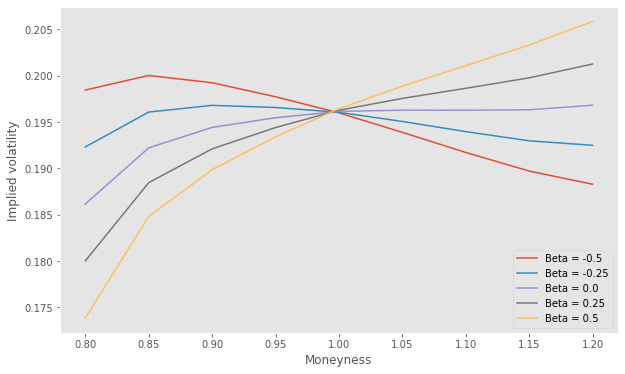

In [358]:
plt.figure(figsize=(10, 6))
for i in range(len(implied_vol)):
    plt.plot(strikes/stock_price, implied_vol[i], label="Beta = {}".format(betas[i])) 
    next 
plt.xlabel('Moneyness')
plt.ylabel('Implied volatility')
plt.legend()
plt.grid()
plt.show()

We can distinguish two groups of skews :
With betas below zero, we found a volatility skew which can be found on equity markets (for low strikes, volatility increases as market thinks downwards movements are more probable).
With betas above zero, volatility is increasing with strikes which indicates that market thinks upwards movements are more probable.


(d) For each value of K and β calculate the corresponding option delta in the CEV model
by bumping the input stock price by 0.1 and recalculating the option price. Make
sure you use the same random number seed when doing the calculations as you will
need to use the same sequence of random numbers for S and S + 0.1. Compare the
deltas calculated to the Black-Scholes model delta and discuss the intuition behind
your results.

In [348]:
stock_price = 100
volatility = 0.2 
risk_free_rate = 0.05
dividend_rate = 0 
steps_number = 25
maturity_in_years = 0.5
simulations_number = 10000
strikes = np.linspace(80,120,9)
discount_factor = exp(-risk_free_rate*maturity_in_years)

In [359]:
#Compute new_option prices with a 0.1 stock bump
betas = np.linspace(-0.5,0.5,5)
option_prices_bumped = []
for i in range(betas.shape[0]): 
    option_prices_bumped.append(Monte_Carlo_CEV(stock_price + 0.1, volatility, risk_free_rate, dividend_rate, steps_number, maturity_in_years , betas[i], simulations_number, "call", strikes))
    next 
option_prices_bumped

[array([22.24324017, 17.7207466 , 13.54128059,  9.86178308,  6.80708653,
         4.42636423,  2.70196112,  1.54703523,  0.83678227]),
 array([22.2134046 , 17.67990032, 13.49968618,  9.83444415,  6.80813749,
         4.45858864,  2.75868915,  1.6143858 ,  0.90103877]),
 array([22.18653955, 17.641457  , 13.45954102,  9.808295  ,  6.81011321,
         4.49215075,  2.81710235,  1.68430775,  0.96906165]),
 array([22.16278177, 17.60547246, 13.42096218,  9.78333896,  6.81315013,
         4.52699325,  2.87723032,  1.75692409,  1.04107351]),
 array([22.14188587, 17.57195147, 13.38386799,  9.75963543,  6.81708081,
         4.56320607,  2.93932663,  1.83258172,  1.11732424])]

In [360]:
option_prices = np.array(option_prices)
option_prices_bumped = np.array(option_prices_bumped)
deltas_CEV = (option_prices_bumped - option_prices) / 0.1
deltas_CEV

array([[0.96381261, 0.92140206, 0.84411874, 0.74089778, 0.61044295,
        0.47107021, 0.33907845, 0.22385862, 0.13268483],
       [0.96500703, 0.9220688 , 0.8427464 , 0.73635481, 0.60463588,
        0.46469431, 0.33558836, 0.22363211, 0.13602914],
       [0.96648914, 0.92282997, 0.84119317, 0.73137072, 0.59805341,
        0.45929124, 0.33260029, 0.22326544, 0.13857924],
       [0.96830404, 0.92406378, 0.84003176, 0.7263984 , 0.59272624,
        0.45384953, 0.32929082, 0.22195387, 0.14128826],
       [0.97021061, 0.92584488, 0.83904129, 0.72147722, 0.58689978,
        0.44754566, 0.32574705, 0.22089034, 0.14319099]])

In [361]:
deltas_BS = np.zeros((betas.shape[0],strikes.shape[0]))
volatility = 0.2 
model = BlackScholes(volatility)

for i in range(betas.shape[0]):
    for j in range(strikes.shape[0]):
        call_option = EquityVanillaOption(expiry_date, strikes[j], OptionTypes.EUROPEAN_CALL)
        deltas_BS[i][j] = call_option.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)    
        next
    next  
deltas_BS

array([[0.96643904, 0.91930355, 0.8400249 , 0.72928982, 0.59734004,
        0.46018919, 0.33350207, 0.22786851, 0.147303  ],
       [0.96643904, 0.91930355, 0.8400249 , 0.72928982, 0.59734004,
        0.46018919, 0.33350207, 0.22786851, 0.147303  ],
       [0.96643904, 0.91930355, 0.8400249 , 0.72928982, 0.59734004,
        0.46018919, 0.33350207, 0.22786851, 0.147303  ],
       [0.96643904, 0.91930355, 0.8400249 , 0.72928982, 0.59734004,
        0.46018919, 0.33350207, 0.22786851, 0.147303  ],
       [0.96643904, 0.91930355, 0.8400249 , 0.72928982, 0.59734004,
        0.46018919, 0.33350207, 0.22786851, 0.147303  ]])

In [362]:
#Compute the spread
deltas_spread = deltas_CEV - deltas_BS
deltas_spread

array([[-2.62643072e-03,  2.09851709e-03,  4.09383459e-03,
         1.16079592e-02,  1.31029109e-02,  1.08810245e-02,
         5.57638456e-03, -4.00988571e-03, -1.46181692e-02],
       [-1.43201112e-03,  2.76525270e-03,  2.72150122e-03,
         7.06499743e-03,  7.29583797e-03,  4.50512240e-03,
         2.08629478e-03, -4.23639652e-03, -1.12738600e-02],
       [ 5.00977591e-05,  3.52642233e-03,  1.16827048e-03,
         2.08090719e-03,  7.13372349e-04, -8.97950137e-04,
        -9.01771731e-04, -4.60306305e-03, -8.72376044e-03],
       [ 1.86499782e-03,  4.76023556e-03,  6.85502491e-06,
        -2.89141605e-03, -4.61379886e-03, -6.33966250e-03,
        -4.21124655e-03, -5.91464184e-03, -6.01473295e-03],
       [ 3.77157367e-03,  6.54133145e-03, -9.83612832e-04,
        -7.81259782e-03, -1.04402638e-02, -1.26435343e-02,
        -7.75501240e-03, -6.97816391e-03, -4.11200532e-03]])

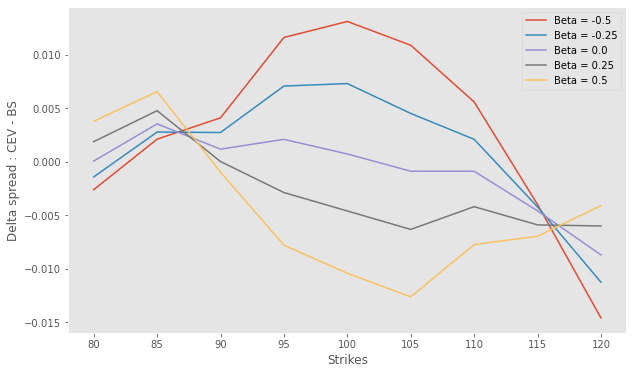

In [363]:
plt.figure(figsize=(10, 6))
for i in range(deltas_spread.shape[0]):
    plt.plot(strikes, deltas_spread[i], label="Beta = {}".format(betas[i])) 
    next 
plt.xlabel('Strikes')
plt.ylabel('Delta spread : CEV - BS')
plt.legend()
plt.grid()
plt.show()

When beta = 0, deltas are very close, which is what we expected. 
When betas are below zero, deltas from CEV model tend to be higher than deltas from BS model : as the strike approaches the spot price, the delta spread increases, for strikes close to the spot, the option price is more sensitive to variations of the underlying price. This relationship seems to invert for strikes far from spot.

When betas are above zero, deltas from CEV model tend to be lower than deltas from BS model : as the strike approaches the spot price, the delta spread decreases, for strikes close to the spot, the option price is less sensitive to variations of the underlying price.

# Dynamic hedging of a variance swap

Calculation of the net proceeds of the dynamic hedging strategy
of investing 2/T dollars per day in the stock. We then combine this with the payoff of a short
position of 2/T log contracts.

In [183]:
#Simulate geometric brownian motion
def gbm(n_years = 1,mu=0.05,sigma=0.3,steps_per_year=252,s_0=100):
    dt = 1/steps_per_year
    n_steps = int(steps_per_year*n_years)
    xi = np.random.normal(size=(n_steps+1)) # generate a normal random number with dimension to our array
    rets=mu*dt+sigma*np.sqrt(dt)*xi
    rets=pd.DataFrame(rets)
    prices=s_0*(1+rets).cumprod()
    prices.iloc[0]=s_0
    
    return prices

def VarSwaps(n_years = 1, mu=0.05, sigma=0.3, steps_per_year=252, s_0=100):
    df = pd.DataFrame(index = np.arange(0,253,1))
    df["Stock Price"] = gbm(n_years = n_years, mu=mu, sigma=sigma, steps_per_year=steps_per_year, s_0=s_0)

    # We our dynamic hedge column: investing 2/252 euros in stock
    df["Stock Position"] = 0
    for i in np.arange(0,253,1):
        df.iloc[i,1] = (2 / 252) / df.iloc[i,0]
        
    # Proceeds from our dynamic hedge
    df["Dynamic Hedge Proceeds"] = 0
    for i in np.arange(1,253,1):
        df.iloc[i,2] = df.iloc[i-1,2] + round((df.iloc[i,0] - df.iloc[i-1,0]) * df.iloc[i-1,1],5)

    #Static hedging: (2/T)* [ - ln(S(t)/S(0)] : we are interested only in the last row 
    df["Static Hedging"] = 0
    for i in np.arange(1,253,1):
        df.iloc[i,3] = - round((2/252) * np.log(df.iloc[i,0] / df.iloc[0,0]),5)
        
    #Replication: sum of dynamic hedging and static hedging
    df["Replication"] = round(df["Dynamic Hedge Proceeds"] + df["Static Hedging"],5)
 
    return   df.iloc[252,:]

In [184]:
VarSwaps()

Stock Price              94.53531449
Stock Position            0.00008395
Dynamic Hedge Proceeds   -0.00014000
Static Hedging            0.00045000
Replication               0.00031000
Name: 252, dtype: float64

Simulation of 1000 paths of the stock price and use them to compute a histogram of the
final P&L of a variance swap that has been hedged dynamically.

In [ ]:
def VarSwaps_scenarios(n_years , mu, sigma, steps_per_year, s_0, n_scenarios):
    dataframe = pd.DataFrame(index=np.arange(0,n_scenarios,1))
    dataframe.index.name = "Scenario n°" 
    dataframe["Final Stock Price"] = 0
    dataframe["Stock Position"] = 0
    dataframe["Dynamic Hedge Proceeds"] = 0
    dataframe["Static Hedging"] = 0
    dataframe["Replication"] = 0
    
    
    for i in range(0, n_scenarios):
        vs = VarSwaps(n_years = 1, mu=0.05, sigma=0.3, steps_per_year=252, s_0=100)

        dataframe.iloc[i,0] = vs[0]
        dataframe.iloc[i,1] = vs[1]
        dataframe.iloc[i,2] = vs[2]
        dataframe.iloc[i,3] = vs[3]
        dataframe.iloc[i,4] = vs[4]
      
   
    #We create a column corresponding to P&L 
    #The payout of the variance swap is based on the replication
    #Here, the variance is supposed to be hedged only dynamically, the P&L in thus the dynamic hedge 
    dataframe["P&L"] = dataframe["Replication"] + dataframe["Dynamic Hedge Proceeds"]
    
    #We plot the histogram
    plt.figure(figsize = (12,12))
    dataframe["P&L"].hist(bins=20, color='red')
    plt.xlabel('P&L with dynamic hedging')
    plt.ylabel('Number of simulation')
    
    return #dataframe["Replicating Error"]

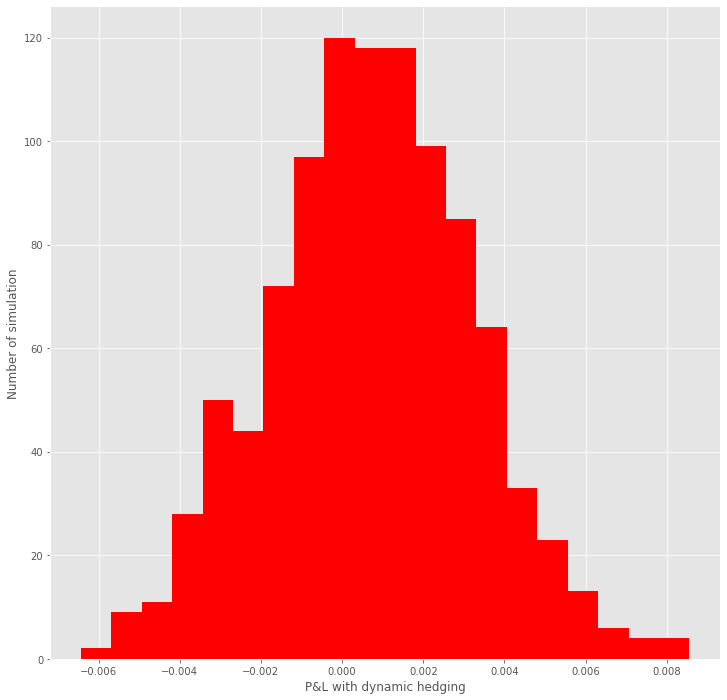

In [188]:
VarSwaps_scenarios(n_years = 1, mu = 0.05, sigma = 0.3, steps_per_year = 252, s_0 = 100,n_scenarios = 1000)

We can observe a large distribution density around 0. The dynamic hedging proves its efficiency. We have a little tail on right, static hedging might correct it.